In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắn index
df = pd.read_csv('/content/drive/MyDrive/Project_dataset/GAS.csv')
df=df.reset_index()['Price']
df

0        98700
1       102900
2        99600
3        97500
4        97200
         ...  
1246     92900
1247     92800
1248     92000
1249     92000
1250     94000
Name: Price, Length: 1251, dtype: int64

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 13s 129ms/step - loss: 0.0515 - val_loss: 0.0530
Epoch 2/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0126 - val_loss: 0.0089
Epoch 3/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0077 - val_loss: 0.0257
Epoch 4/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0065 - val_loss: 0.0093
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0051 - val_loss: 0.0089
Epoch 6/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0111
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0099
Epoch 8/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0044 - val_loss: 0.0100
Epoch 9/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0044 - val_loss: 0.0098
Epoch 10/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0042 - val_loss: 0.00

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 27ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
train_size1 = int(0.6 * len(df))
test_size1 = int(0.3 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [13]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 9270.172022364579
Testing RMSE: 14520.650595313737
Validation MAPE: 7.718432090034956
Testing MAPE: 11.81923028825044
Validation MAE: 8089.8575
Testing MAE: 11486.702705596106


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=66
i=0
while(i<30):

    if(len(temp_input)>66):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.52592695]
67
1 day input [0.66760733 0.66107497 0.65062319 0.66107497 0.67936558 0.69112383
 0.69373677 0.70810797 0.70288208 0.69373677 0.66238144 0.65062319
 0.64147788 0.64409083 0.64017141 0.63494552 0.63363905 0.62841316
 0.65062319 0.63886494 0.63363905 0.62841316 0.63494552 0.62710669
 0.62710669 0.6218808  0.61796138 0.59575135 0.60097724 0.59967077
 0.60228371 0.57746074 0.56570249 0.5604766  0.54479893 0.55002482
 0.54218599 0.51213713 0.49776593 0.51605654 0.50037888 0.50821771
 0.49776593 0.49645946 0.51213713 0.52520185 0.5134436  0.50037888
 0.50429829 0.50037888 0.50299182 0.49645946 0.51083066 0.53565363
 0.53304068 0.5134436  0.50429829 0.53304068 0.51997596 0.52128243
 0.50952418 0.50821771 0.49776593 0.49776593 0.52389538 0.52592695]
1 day output [[0.53935593]]
2 day input [0.66107497 0.65062319 0.66107497 0.67936558 0.69112383 0.69373677
 0.70810797 0.70288208 0.69373677 0.66238144 0.65062319 0.64147788
 0.64409083 0.64017141 0.63494552 0.63363905 0.62841316 0.65

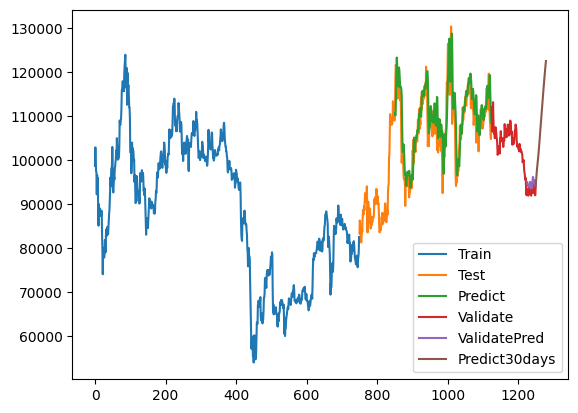

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()